### Fourier Analysis

In [1]:
import glob
import os
import numpy as np
from skimage import io, transform, exposure, restoration, filters
import matplotlib.pyplot as plt
import tqdm
import panel as pn
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft2, fftshift
from skimage import img_as_float
from skimage.color import rgb2gray
from skimage.data import astronaut
from skimage.filters import window
pn.extension()

/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# I saved the four test videos in data_dir 
home_dir = os.path.expanduser('~')
data_dir = os.path.join('data')
file_list = sorted(glob.glob(data_dir + '/*'))

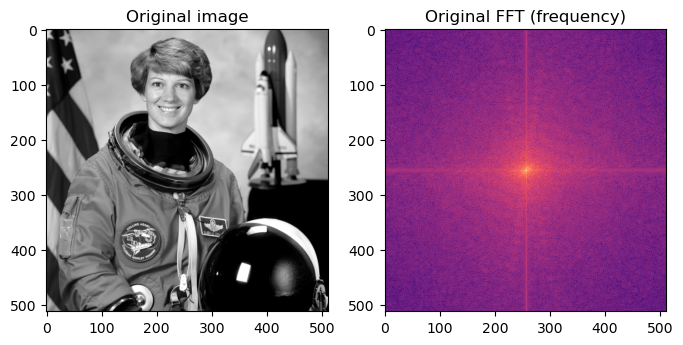

In [8]:
image = img_as_float(rgb2gray(astronaut()))


image_f = np.abs(fftshift(fft2(image)))
wimage_f = np.abs(fftshift(fft2(wimage)))

fig, axes = plt.subplots(1,2, figsize=(8, 8))
ax = axes.ravel()
ax[0].set_title("Original image")
ax[0].imshow(image, cmap='gray')

ax[1].set_title("Original FFT (frequency)")
ax[1].imshow(np.log(image_f), cmap='magma')

plt.show()

## Data loader

In [27]:
# idx indexes the list of videos
idx = 1
ims = io.imread(file_list[idx])
output_shape = (512,512)

In [28]:
# Most skimage functions can only take one image at a time
# We need to implement loops several times because we have videos
def apply_function_to_ims(ims, function, new_shape = None, **kwargs):
    if not new_shape:
        new_shape = ims.shape
    output_ims = np.zeros(new_shape).astype('float32')
    for i, _ in enumerate(tqdm.tqdm(ims)): # loop over images
        output_ims[i,:,:]  = function(ims[i,:,:], **kwargs)
    return output_ims

# skimage thresholding functions only give you the scalar value of the threshold
# we need to create the binary masks using the threshold
def thresholding(im, thresholding_function = None):
    return (im > thresholding_function(im)).astype('float32')

## Segmentation

In [29]:
# resize images to make computation faster
X_scaled = apply_function_to_ims(
    ims[:, 0, :,:], 
    transform.resize, 
    new_shape = (ims.shape[0], *output_shape), 
    output_shape = output_shape,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 260/260 [00:24<00:00, 10.49it/s]


In [30]:
X_f = np.abs(fftshift(fft2(X_scaled)))

In [31]:
# Denoising the images helps get better thresholding results
X_denoised = apply_function_to_ims(X_scaled, restoration.denoise_bilateral)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 260/260 [00:25<00:00, 10.32it/s]


In [32]:
# Apply threshold and create binary masks
# You can change the type of thresholding method used
# Depending on your video, some work better, so it is good to try some of them
# I highly recommend otsu and triangle
# https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html
X_thresh = apply_function_to_ims(X_denoised, thresholding, thresholding_function = filters.threshold_triangle)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 260/260 [00:00<00:00, 449.36it/s]


In [33]:
# We will use the binarized illumination region image to set to 0 all the pixels in our
# aster video that are outside of illumination region.
illumination_mask = transform.resize(ims[0,1,:,:], output_shape)
# I found this threshold (.00175) by looking at histogram of the illumination region image.
illumination_mask = (illumination_mask > 0.0016).astype('float32')
unique, counts = np.unique(illumination_mask, return_counts=True)
dict(zip(unique, counts))
X_thresh = X_thresh * illumination_mask
#print(illumination_mask)
#X_thresh

Column
    [0] Column
        [0] IntSlider(end=259, name='i')
    [1] Row
        [0] Matplotlib(Figure, name='interactive00124')
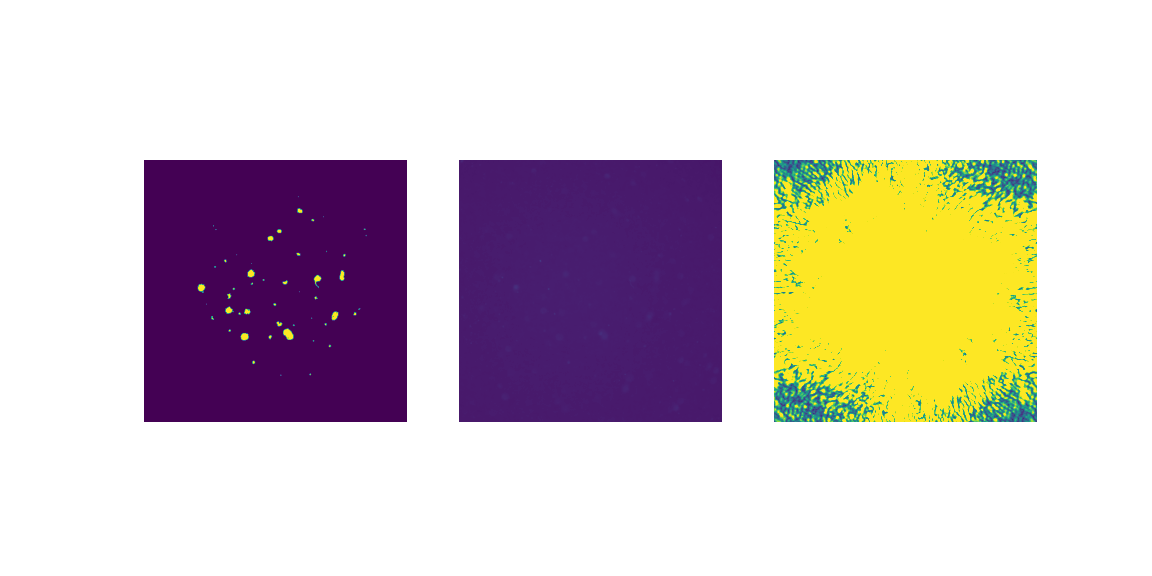

In [34]:
# Display results
def display_images(i = 0):
    f = plt.figure(figsize= (8,4))
    plt.subplot(1,3,1)
    plt.imshow(X_thresh[i,:,:])
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(X_scaled[i,:,:], vmin = .0, vmax = .4)
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(X_f[i,:,:], vmin = .0, vmax = .4)
    plt.axis('off')
    plt.close()
    return f
pn.interact(display_images, i = (0, ims.shape[0]-1))